In [1]:
import pyTigerGraph as tg
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import sklearn

In [2]:
conn = tg.TigerGraphConnection(graphname="SCOTUS_Graph")

In [3]:
with open("../graph_creation/gsql/queries/tg_fastRP.gsql", "r") as f:
    fast_rp_query = f.read()

In [4]:
def constructParamUrl(v_types, e_types, params):
    paramUrl = ""
    for vType in v_types:
        paramUrl += ("v_type="+vType+"&")
    for eType in e_types:
        paramUrl += ("e_type="+eType+"&")
    for p in params.keys():
        paramUrl += (p+"="+str(params[p])+"&")
    paramUrl = paramUrl[:-1]
    return paramUrl

In [5]:
params = {
    "weights":"2,3,4",
    "beta":-0.1387,
    "k":1,
    "reduced_dim":512, 
    "sampling_constant":3,
    "random_seed":42, 
    "result_attr":"embedding"
}

transform = "concat"

edgeTypes = conn.getEdgeTypes() + ["STATE_CONTAINS_PETITIONER", 
                                   "STATE_CONTAINS_RESPONDENT", "PETITIONER_TYPE_IN_CASE", 
                                   "RESPONDENT_TYPE_IN_CASE", "ORIGIN_OF_CASE",
                                   "STATE_ORIGIN_OF_CASE", "ISSUE_OF_CASE",
                                   "AREA_CONTAINS_ISSUE", "VOTED_CONSERVATIVE",
                                   "VOTED_LIBERAL"]  # Have to get reverse edges too, except CITED_BY, which would be forward-looking

vertexTypes = conn.getVertexTypes()

labels = {"LIBERAL_VOTE": 1,
          "CONSERVATIVE_VOTE": 0}

justices = conn.getVertices("Justice")
justices = [x["v_id"] for x in justices]

In [6]:
paramUrl = constructParamUrl(vertexTypes, edgeTypes, params)
conn.gsql("USE GRAPH "+conn.graphname+"\n"+"DROP QUERY tg_fastRP")
queryDef = "USE GRAPH "+conn.graphname+"\n"+fast_rp_query.replace("@embedding_dim@", str(params["reduced_dim"]))
conn.gsql(queryDef)
conn.runInstalledQuery("tg_fastRP", params=paramUrl, timeout=512_000)

[]

In [7]:
def createTransform(X, embedding_dim=200, method="L2"):
    case = X[:,:embedding_dim]
    justice = X[:,embedding_dim:]
    if method == "L2":
        return (case-justice)**2
    elif method == "hadamard":
        return np.multiply(case, justice)
    elif method == "L1":
        return np.abs(case-justice)
    elif method == "avg":
        return (case+justice)/2
    elif method == "concat":
        return X
    else:
        raise("Invalid transform method")

In [8]:
def createTrainData(justices, embeddingDim):
    Xdata = []
    ydata = []
    for justice in justices:
        res = conn.runInstalledQuery("justiceCaseLinks", params={"justiceID": int(justice), "train":True})
        caseEmbeddings = pd.DataFrame.from_dict(res[0]["@@caseEmbeddings"], orient="index").reset_index().rename(columns={"index":"caseId"})
        caseVotes = pd.DataFrame.from_dict(res[0]["@@caseVote"], orient="index").reset_index().rename(columns={"index":"caseId", 0:"vote"})
        train_data = caseVotes.merge(caseEmbeddings, on="caseId")
        res = conn.runInstalledQuery("justiceCaseLinks", params={"justiceID": int(justice), "valid":True})
        caseEmbeddings = pd.DataFrame.from_dict(res[0]["@@caseEmbeddings"], orient="index").reset_index().rename(columns={"index":"caseId"})
        caseVotes = pd.DataFrame.from_dict(res[0]["@@caseVote"], orient="index").reset_index().rename(columns={"index":"caseId", 0:"vote"})
        valid_data = caseVotes.merge(caseEmbeddings, on="caseId")
        data = pd.concat([train_data, valid_data])
        justiceEmbedding = pd.DataFrame.from_dict(res[0]["@@justiceEmbedding"], orient="index").reset_index().rename(columns={"index":"justice"})
        X = data[[i for i in range(0,embeddingDim)]].values
        je = justiceEmbedding[[i for i in range(0,embeddingDim)]].values
        je = np.tile(je, (X.shape[0], 1))
        X = np.append(X, je, axis=1)
        y = np.array([labels[x] for x in data["vote"]])
        Xdata.append(X)
        ydata.append(y)
    return np.concatenate(Xdata), np.concatenate(ydata)

In [9]:
def createTestData(justices, embeddingDim):
    Xdata = []
    ydata = []
    for justice in justices:
        res = conn.runInstalledQuery("justiceCaseLinks", params={"justiceID": int(justice), "test":True})
        caseEmbeddings = pd.DataFrame.from_dict(res[0]["@@caseEmbeddings"], orient="index").reset_index().rename(columns={"index":"caseId"})
        caseVotes = pd.DataFrame.from_dict(res[0]["@@caseVote"], orient="index").reset_index().rename(columns={"index":"caseId", 0:"vote"})
        data = caseVotes.merge(caseEmbeddings, on="caseId")
        justiceEmbedding = pd.DataFrame.from_dict(res[0]["@@justiceEmbedding"], orient="index").reset_index().rename(columns={"index":"justice"})
        X = data[[i for i in range(0,embeddingDim)]].values
        je = justiceEmbedding[[i for i in range(0,embeddingDim)]].values
        je = np.tile(je, (X.shape[0], 1))
        X = np.append(X, je, axis=1)
        y = np.array([labels[x] for x in data["vote"]])
        Xdata.append(X)
        ydata.append(y)
    return np.concatenate(Xdata), np.concatenate(ydata)

In [10]:
X_train, y_train = createTrainData(justices, params["reduced_dim"])
X_train = createTransform(X_train, params["reduced_dim"], transform)
X_test, y_test = createTestData(justices, params["reduced_dim"])
X_test = createTransform(X_test, params["reduced_dim"], transform)
clf = LogisticRegression(solver="lbfgs", max_iter=1000)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.58      0.59      7267
           1       0.64      0.67      0.65      8090

    accuracy                           0.63     15357
   macro avg       0.62      0.62      0.62     15357
weighted avg       0.62      0.63      0.62     15357



In [12]:
print(accuracy)

0.6253174448134401


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, clf.predict(X_test))

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

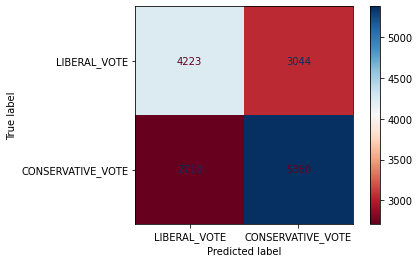

In [15]:
disp.plot(cmap='RdBu')